<a href="https://colab.research.google.com/github/Leomutz/NIDS1/blob/main/hyper_parameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

df_heart = pd.read_csv('/content/heart.csv')

lables=['<45', '45-60', '60+']
df_heart['age_bins']=pd.cut(x=df_heart['age'],bins=[25,45,60,100], labels=lables, include_lowest=True)

numeric_var = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
categorical_var = ['sex','cp','fbs','restecg','exng','slp','caa','thall', 'age_bins']

df_heart[categorical_var] = df_heart[categorical_var].astype('category')

X = df_heart.drop('output', axis=1)
y = df_heart['output']

In [4]:
X.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,age_bins
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,60+
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,<45
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,<45
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,45-60
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,45-60


In [5]:
y.head()

,output
0,1
1,1
2,1
3,1
4,1


In [6]:
from sklearn.pipeline import Pipeline #sklearn==0.23.2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier

tuples = list()

tuples.append((Pipeline([
        ('scaler', StandardScaler()),
    ]), numeric_var))

tuples.append((Pipeline([
        ('onehot', OneHotEncoder()),
    ]), categorical_var))

preprocess = make_column_transformer(*tuples)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('classifier', LGBMClassifier())
])

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": [0.0001, 0.0005, 0.001, 0.01, 0.1],
    "classifier__n_estimators": [100, 300, 600, 800, 1000],
    "classifier__max_depth": [ 4, 20, 100, 250, 400]
}

# grid
reg_grid = GridSearchCV(pipe,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=8,
                        scoring='roc_auc'
                       )

model_grid = reg_grid.fit(X, y)

[LightGBM] [Info] Number of positive: 165, number of negative: 138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 303, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544554 -> initscore=0.178692
[LightGBM] [Info] Start training from score 0.178692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

n_iter = 70

param_grid = {
    "classifier__learning_rate": loguniform(1e-4, 0.1),
    "classifier__n_estimators": randint(100,1000),
    "classifier__max_depth": randint(4, 400)
}

# Random
reg_rand = RandomizedSearchCV(pipe,
                         param_distributions=param_grid,
                         n_iter=n_iter,
                         cv=5,
                         n_jobs=8,
                         scoring='roc_auc',
                         random_state=123)

model_rand = reg_rand.fit(X, y)

[LightGBM] [Info] Number of positive: 165, number of negative: 138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 303, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544554 -> initscore=0.178692
[LightGBM] [Info] Start training from score 0.178692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

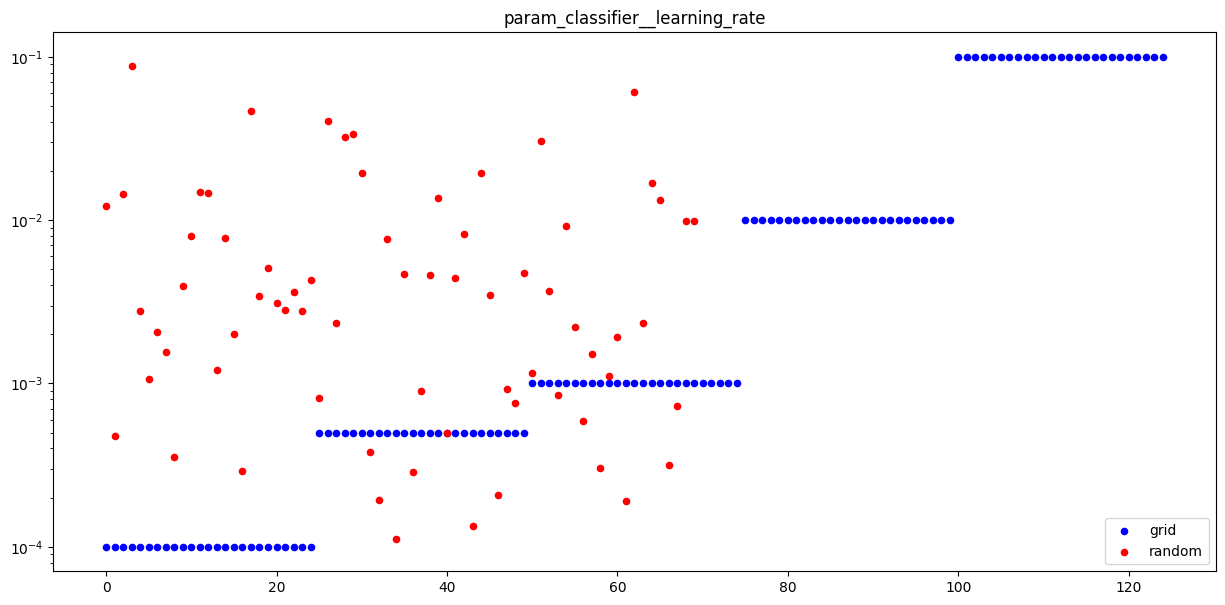

In [13]:
import matplotlib.pyplot as plt
import numpy as np

param = 'param_classifier__learning_rate'

grid = model_grid.cv_results_[param]
rand = model_rand.cv_results_[param]
#bay = model_bay.cv_results_[param]

fig = plt.figure(figsize=(15, 7))

ax = plt.gca()
ax.scatter(np.arange(len(grid)), grid.data, c='b', s=20, label='grid');
ax.scatter(np.arange(len(rand)), rand.data, c='r', s=20, label='random');
#ax.scatter(np.arange(len(bay)), bay, c='g', s=20, label='bayesian');
ax.set_yscale('log')

plt.legend();
plt.title(param);